In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os 
import cv2
import math
import scipy.io as sio
import tensorflow as tf
import time
from time import ctime
from tqdm import tqdm
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical

os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1, 2"

In [23]:
# pip install tensorflow-addons

In [24]:
# Check GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)

# assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_memory_growth(physical_devices[1], True)
# tf.config.experimental.set_memory_growth(physical_devices[2], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [25]:
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (Input, Dense, Dropout, Activation,
                                     Flatten, BatchNormalization, Conv3D,
                                     MaxPooling3D,ZeroPadding3D,SpatialDropout3D)
from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras import regularizers

In [26]:
with open('./list/c3d_train002.txt', 'r') as f:
# with open('./list/c3d_train001.txt', 'r') as f:
# with open('./list/c3d_train01.txt', 'r') as f:
# with open('./list/c3d_train01-Copy1.txt', 'r') as f:
        lines = f.read().split('\n')
    
tr_files = [line for line in lines if len(line) > 0]
tr_files = shuffle(tr_files)

In [27]:
X_trainDataset = []
Y_trainDataset = []
FRAMES = 16
for idx, tr_file in enumerate(tr_files):
    # print(tr_file.split(' '))
    path, frm, cls = tr_file.split(' ')
 
    A = [0,0,0,0,0,0,1,2,3,4,5,6,7,8,9,10]
    B = [int(frm)-11, int(frm)-10, int(frm)-9, int(frm)-8, int(frm)-7, int(frm)-6, int(frm)-5, int(frm)-4, int(frm)-3, int(frm)-2,  
         int(frm)-1, int(frm)-1, int(frm)-1, int(frm)-1, int(frm)-1, int(frm)-1]    
    X_trainDataset.append([ path + 'frm_%06d.jpg' % (f + 1) for f in A])
    Y_trainDataset.append(cls)
    X_trainDataset.append([ path + 'frm_%06d.jpg' % (f + 1) for f in B])
    Y_trainDataset.append(cls)
    X_trainDataset.append([ path + 'frm_%06d.jpg' % (f + 1) for f in range(0, 0 + FRAMES)])
    Y_trainDataset.append(cls)
    X_trainDataset.append([ path + 'frm_%06d.jpg' % (f + 1) for f in range((int(frm)//2) - 8, (int(frm)//2) + 8)])
    Y_trainDataset.append(cls)
    X_trainDataset.append([ path + 'frm_%06d.jpg' % (f + 1) for f in range(int(frm)-FRAMES - 0, int(frm) - 0)])
    Y_trainDataset.append(cls)

In [28]:
# import random
# XX = []
# YY = []
# for i in range(5):
#     temp = []
#     for j in range(4):
#         a = random.randint(0,5999)  
#         af = tr_files[a]
#         path, frm, cls = af.split(' ')
#         aa = random.randint(0,int(frm)-5)
#         temp += [ path + 'frm_%06d.jpg' % (f + 1) for f in range(aa, aa + 4)]
#     XX.append(temp)
#     YY.append(str(6))
    
# print(XX[0])
# print(YY[0])
# print(np.array(XX).shape)

In [29]:
# X.sort()
# print(X)
np.array(X_trainDataset).shape

(60060, 16)

In [30]:
print(len(X_trainDataset))
print(len(Y_trainDataset))

60060
60060


In [31]:
from tqdm import tqdm
idx = 0
rf = []
ud = []
rfb = []
udb = []
def rescale_img(data_list):
    global idx
    st = time.time()
    realDataset = []
    for i in tqdm(data_list):
        cubedata = []
        # print(type(i))
        for j in i:
#             print(j)
            img = cv2.imread(j)[:, :, ::-1]
            height, width = 128, 171
            scale = 136
            img = cv2.resize(img, (width, height), interpolation = cv2.INTER_LINEAR)
            off_h = abs(np.ceil((height - scale) / 2).astype(int))
            off_w = abs(np.ceil((width - scale) / 2).astype(int))
            img = img[off_h:off_h + scale, off_w:off_w + scale, :]
            img = cv2.resize(img, (112, 112), interpolation = cv2.INTER_LINEAR)
            
            ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
            channels = cv2.split(ycrcb)
            cv2.equalizeHist(channels[0],channels[0])
            cv2.merge(channels,ycrcb)
            img = cv2.cvtColor(ycrcb, cv2.COLOR_YCR_CB2BGR)
            
            edge = cv2.Laplacian(img, cv2.CV_64F)
            edge_x = cv2.Sobel(img, cv2.CV_16S, 1,0)
            edge_y = cv2.Sobel(img, cv2.CV_16S, 0,1)
            sharp = img -0.7 * edge+ 0.15* edge_x + 0.15* edge_y
            sharp[sharp > 255] = 255
            sharp[sharp < 0] = 0
            SHARP = sharp.astype('uint8')            

                    
            cubedata.append(SHARP)
            # cubedata.append(img)
        
        # Random flip
        is_flip_rf = np.random.rand(1, 1).squeeze() > 0.5
        rfb.append(is_flip_rf)
        
        is_flip_ud = np.random.rand(1, 1).squeeze() > 0.5
        udb.append(is_flip_ud)
        
        if is_flip_rf and not(is_flip_ud):
            voxel = np.flip(cubedata, axis=2)
            rf.append(idx)
        elif not(is_flip_rf) and is_flip_ud:
            voxel = np.flip(cubedata, axis=1)
            ud.append(idx)
        elif not(is_flip_rf) and not(is_flip_ud):
            voxel = cubedata.copy()
        elif is_flip_rf and is_flip_ud:
            voxel = cubedata.copy()
            
        realDataset.append(voxel)
        idx+=1
                
#         realDataset.append(cubedata)
    et = time.time()
    print((et-st)/60)
    # return np.array(realDataset).astype('float32')/1.
    return np.array(realDataset)

In [32]:
X = rescale_img(X_trainDataset)

100%|██████████| 60060/60060 [34:14<00:00, 29.23it/s]  


34.24893986384074


In [33]:
# np.save('./train_dataset_img', X)

In [12]:
X.shape

(60060, 16, 112, 112, 3)

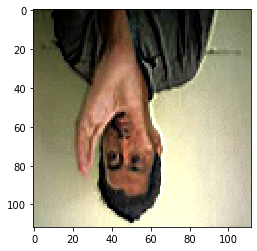

In [56]:
plt.imshow(X[2][7])
plt.show()

In [44]:
flip_i = 0
for k,v in enumerate(rfb):
    if v and not(udb[k]):
#         print(k,v,udb[k])
        flip_i+=1
    elif not(v) and udb[k]:
#         print(k,v,udb[k])
        flip_i+=1
# for k,v in enumerate(ud):
#     if v:
#         print(k)   
print(flip_i)
print(len(rf))
print(len(ud))

1 True 2
4 True 29
15 True 78
17 True 83
20 True 95
23 True 109
27 True 135
35 True 186
39 True 199
41 True 209
44 True 220
50 True 237
52 True 248
57 True 268
61 True 284
63 True 298
65 True 310
67 True 312
68 True 313
74 True 332
75 True 337
86 True 400
90 True 417
93 True 425
98 True 445
99 True 448
114 True 526
121 True 550
123 True 555
124 True 556
128 True 577
131 True 593
133 True 612
141 True 637
154 True 697
157 True 713
158 True 714
159 True 718
161 True 721
162 True 725
165 True 740
168 True 753
171 True 785
174 True 797
175 True 798
181 True 818
182 True 819
191 True 841
196 True 858
202 True 895
208 True 935
211 True 964
212 True 974
214 True 978
215 True 981
228 True 1056
233 True 1083
234 True 1090
245 True 1119
254 True 1169
258 True 1180
259 True 1181
269 True 1244
274 True 1256
279 True 1274
280 True 1280
285 True 1302
287 True 1317
289 True 1328
294 True 1359
300 True 1374
306 True 1394
307 True 1398
314 True 1430
318 True 1447
320 True 1459
322 True 1461
330 True 14

IndexError: list index out of range

In [40]:
# change class mapping
rf_map = {'0':'1','1':'0','2':'2','3':'3','4':'5','5':'4'}

ud_map = {'0':'0','1':'1','2':'3','3':'2','4':'4','5':'5'}

for vrf in rf:
    print(Y_trainDataset[vrf])
    Y_trainDataset[vrf] = rf_map[str(Y_trainDataset[vrf])]
    print(Y_trainDataset[vrf])
for vud in ud:
    print(Y_trainDataset[vud])
    Y_trainDataset[vud] = ud_map[str(Y_trainDataset[vud])]
    print(Y_trainDataset[vud])


5
4
5
4
3
3
3
3
2
2
2
2
3
3
4
5
4
5
2
2
2
2
2
2
2
2
3
3
1
0
1
0
5
4
5
4
5
4
2
2
2
2
4
5
2
2
2
2
0
1
0
1
1
0
2
2
2
2
2
2
3
3
3
3
3
3
4
5
1
0
1
0
1
0
1
0
3
3
3
3
5
4
5
4
0
1
0
1
0
1
3
3
3
3
5
4
2
2
4
5
4
5
5
4
5
4
5
4
2
2
2
2
0
1
0
1
3
3
3
3
0
1
0
1
1
0
5
4
1
0
3
3
0
1
0
1
0
1
2
2
3
3
5
4
5
4
5
4
3
3
0
1
0
1
3
3
3
3
5
4
5
4
2
2
2
2
0
1
0
1
1
0
1
0
2
2
0
1
0
1
0
1
5
4
5
4
5
4
3
3
3
3
5
4
4
5
4
5
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
4
5
4
5
4
5
0
1
0
1
0
1
0
1
1
0
1
0
1
0
2
2
2
2
2
2
2
2
5
4
4
5
3
3
4
5
0
1
5
4
5
4
1
0
4
5
4
5
0
1
0
1
0
1
0
1
5
4
1
0
1
0
0
1
0
1
2
2
2
2
2
2
5
4
1
0
2
2
2
2
3
3
3
3
3
3
4
5
4
5
3
3
3
3
3
3
3
3
2
2
2
2
2
2
2
2
2
2
0
1
2
2
4
5
4
5
4
5
4
5
3
3
0
1
0
1
4
5
4
5
2
2
2
2
3
3
3
3
3
3
0
1
0
1
0
1
4
5
4
5
0
1
5
4
4
5
3
3
3
3
4
5
4
5
4
5
4
5
4
5
2
2
5
4
3
3
1
0
5
4
1
0
1
0
1
0
1
0
3
3
5
4
5
4
5
4
5
4
5
4
4
5
4
5
3
3
2
2
3
3
3
3
3
3
3
3
3
3
0
1
0
1
5
4
5
4
5
4
3
3
5
4
5
4
2
2
2
2
5
4
4
5
0
1
0
1
0
1
5
4
5
4
5
4
5
4
1
0
1
0
2
2
2
2
0
1
4
5
0
1
0
1
0
1
1
0
1
0
1
0
1
0
3
3


In [41]:
y = np.array(Y_trainDataset)
Y = to_categorical(y,)
Y

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.]], dtype=float32)

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
x_train, x_test, y_train, y_test= train_test_split(X,Y,test_size=0.2, random_state=42)

In [17]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(48048, 16, 112, 112, 3)
(12012, 16, 112, 112, 3)
(48048, 6)
(12012, 6)


In [18]:
# def C3DNN_Gesture(training):
# 20201011 add dense layer regularizers
# 20201011 add conv3D SpatialDropout3D(0.25)
def C3DNN_Gesture():
    inputs = Input(shape=(16, 112, 112, 3))
    x = inputs - tf.constant([96.6], dtype=tf.float32, shape=[1, 1, 1, 1, 1])
    x = Conv3D(64, 3, padding='same', activation='relu')(x)
    x = MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), padding='same')(x)
    
    x = Conv3D(128, 3, padding='same', activation='relu')(x)
    x = MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='same')(x)
    
    x = Conv3D(256, 3, padding='same', activation='relu')(x)
#     ########################################################
#     x = SpatialDropout3D(0.25)(x)
#     ########################################################
    x = Conv3D(256, 3, padding='same', activation='relu')(x)
    x = MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='same')(x)
    
    x = Conv3D(512, 3, padding='same', activation='relu')(x)
#     ########################################################
#     x = SpatialDropout3D(0.25)(x)
#     ########################################################
    x = Conv3D(512, 3, padding='same', activation='relu')(x)
    x = MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='same')(x)
    x = ZeroPadding3D(padding=((1,1), (1,1), (1,1)),)(x)
    
    ########################################################
    x = SpatialDropout3D(0.25)(x)
    ########################################################
    
    x = Conv3D(512, 3, padding='valid', activation='relu')(x)
    x = ZeroPadding3D(padding=((1,1), (1,1), (1,1)),)(x)
    
    ########################################################
    x = SpatialDropout3D(0.25)(x)
    ########################################################
    
    x = Conv3D(512, 3, padding='valid', activation='relu')(x)
    x = MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='same')(x)
    
    x = Flatten()(x)
    x = Dense(4096, activation='relu',
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4),
                    bias_regularizer = regularizers.l2(1e-4),
                    activity_regularizer = regularizers.l2(1e-5))(x)

    x = Dropout(rate=0.5,seed=None)(x)
    
    x = Dense(4096, activation='relu',
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4),
                    bias_regularizer = regularizers.l2(1e-4),
                    activity_regularizer = regularizers.l2(1e-5))(x)

    x = Dropout(rate=0.5,seed=None)(x)
    
    outputs = Dense(6, activation='softmax', kernel_initializer = tf.random_normal_initializer(mean=0.0, stddev=0.001), bias_initializer = keras.initializers.Zeros())(x)
    
    return Model(inputs ,outputs)
    

In [19]:
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])
# strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1", "/gpu:2"])
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 2


In [20]:
BATCH_SIZE_PER_REPLICA = 32
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

In [21]:
weights = sio.loadmat('./pretrained/c3d_sports1m_tf.mat', squeeze_me=True)['weights']
Weights = weights.tolist()
len(Weights)

22

In [22]:
learning_rate = 0.001

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

Optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)

epochs = 30

In [24]:
with strategy.scope():
    model = C3DNN_Gesture()

    init_weight = model.get_weights()
    last_one = init_weight[21]
    last_two = init_weight[20]
    
    load_Weight = Weights[0:20]
    load_Weight.append(last_two)
    load_Weight.append(last_one)
    load_weight = np.array(load_Weight)
    model.set_weights(load_weight)

    model.compile(loss = 'categorical_crossentropy', optimizer = Optimizer, metrics = ['accuracy'])
    

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [25]:
model_dir = './Model/model-logs'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    
times = time.strftime("%Y-%m-%d_%H-%M-%S", time.localtime())

logfiles = model_dir + '/{}'.format('basic_model')

model_cbk = keras.callbacks.TensorBoard(log_dir=logfiles,
                                            histogram_freq=1)

modelfiles = model_dir + '/{}-best-model-{}.h5'.format('basic_model',times)
# modelfiles = model_dir + '/{}-best-model.h5'.format('basic_model')
model_mckp = keras.callbacks.ModelCheckpoint(modelfiles,
                                             monitor='val_accuracy',
                                             save_best_only=True)

callbacks_list = [model_cbk, model_mckp]

In [ ]:
print(ctime())
history = model.fit(x=x_train, y=y_train, batch_size=BATCH_SIZE, epochs=epochs, validation_data=(x_test, y_test), shuffle=True, callbacks=callbacks_list)
print(ctime())

Tue Oct 20 18:15:57 2020
Train on 48048 samples, validate on 12012 samples
Epoch 1/30
INFO:tensorflow:batch_all_reduce: 22 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 22 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:Reduce to /job:localhost/replica:0

In [ ]:
train_history = ['loss', 'val_loss', 'accuracy', 'val_accuracy']
name_history = ['training_loss', 'val_loss', 'training_acc', 'val_acc']

plt.figure(figsize=(12, 5))
for eachx, eachy, i in zip(train_history, name_history, range(4)):
    if i % 2 == 0:
        plt.subplot(1, 2, i//2+1)
    l_x = len(history.history[eachx])
    
    plt.plot(np.arange(l_x), history.history[eachx], label=eachy)
    plt.legend(loc='best')
    plt.title('model '+eachy)

plt.savefig("acc_val_K3DCNN.png")
plt.show()

In [ ]:
# ========================================================================================================= #

In [ ]:
# ========================================================================================================= #

In [31]:
# load val data and 

In [4]:
with open('./list/c3d_val001.txt', 'r') as f:
# with open('./list/c3d_val02.txt', 'r') as f:
        lines = f.read().split('\n')
val_files = [line for line in lines if len(line) > 0]
val_files = shuffle(val_files)

In [5]:
len(val_files)

6000

In [6]:
# put 16 frmae of every validate folder into list
X_validateDataset = []
Y_validateDataset = []
FRAMES = 16
for idx, val_file in enumerate(val_files):
    path, st, cls, frm = val_file.split(' ')
    X_validateDataset.append([ path + 'frm_%06d.jpg' % (f + 1) for f in range((int(frm)//2)-8, (int(frm)//2)+8)])
    Y_validateDataset.append(cls)
    

In [7]:
# X_validateDataset[0:3]
# Y_validateDataset[0:3]
len(X_validateDataset)

6000

In [8]:
from tqdm import tqdm
import time
def validate_rescale_img(data_list):
    ST = time.time()
    realDataset = []
    for i in tqdm(data_list):
        cubedata = []
        # print(type(i))
        for j in i:
            # print(j)
            img = cv2.imread(j)[:, :, ::-1]
            height, width = 128, 171
            scale = 136
            img = cv2.resize(img, (width, height), interpolation = cv2.INTER_LINEAR)
            off_h = abs(np.ceil((height - scale) / 2).astype(int))
            off_w = abs(np.ceil((width - scale) / 2).astype(int))
            img = img[off_h:off_h + scale, off_w:off_w + scale, :]
            img = cv2.resize(img, (112, 112), interpolation = cv2.INTER_LINEAR)

            cubedata.append(img)

        realDataset.append(cubedata)
    ET = time.time()
    print((ET-ST)/60)
    return np.array(realDataset)

In [9]:
X_val = validate_rescale_img(X_validateDataset)

100%|██████████| 6000/6000 [03:03<00:00, 32.64it/s]


3.064077456792196


In [10]:
X_val.shape

(6000, 16, 112, 112, 3)

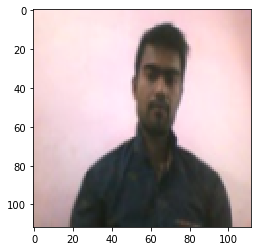

In [11]:
plt.imshow(X_val[0][10])
plt.show()

In [12]:
y_val = np.array(Y_validateDataset)
Y_val = to_categorical(y_val,)

In [13]:
print(X_val.shape)
print(Y_val.shape)

(6000, 16, 112, 112, 3)
(6000, 6)


In [14]:
from tensorflow.keras.models import load_model

In [17]:
new_model = load_model('./Model/model-logs/basic_model-best-model-2020-10-11_16-41-12.h5') 
# new_model = load_model('./Model/model-logs/basic_model-best-model-2020-10-18_00-57-57.h5') #0.86
# new_model = load_model('./Model/model-logs/basic_model-best-model-2020-10-15_17-17-52.h5')
# new_model = load_model('./Model/model-logs/basic_model-best-model-2020-10-12_20-28-06.h5') #0.92
# new_model = load_model('./Model/model-logs/basic_model-best-model-2020-10-09_20-11-11.h5') #0.89

In [18]:
val_loss,val_accuracy = new_model.evaluate(X_val,Y_val)

6000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [2]:
# from tensorflow.keras.models import load_model

In [3]:
# new_model = load_model('./Model/model-logs/basic_model-best-model.h5')

In [5]:
# new_model.summary()

In [ ]:
# y_pred = new_model.predict(std_X_test)

In [ ]:
# y_label = np.argmax(y_pred, axis=1)